# FIRE

To do:
* Incorperate SS measure once all v all blast is complete
* Incorperate RNAInter Database format

In [1]:
import sys
sys.path.append("..")

from Utils.negative_sampling import magnitude, IterableProteinEmbedding, FIREDataFrameGenerator, FIRE

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn; sbn.set_style('ticks')
import matplotlib.gridspec as gridspec
import numpy as np

# Parse files
import pandas as pd

from Bio import SeqIO

from itertools import combinations
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("../Data/TrainingData/PositiveSamples/RNAInter_small_interactions_current.csv", index_col = 0).reset_index()
df['interacts'] = 1

print(df.shape)
df.head()

(12161, 15)


,index,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGC...,1
1,911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTG...,1
2,912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAA...,1
3,912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1
4,2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1


In [3]:
# Only generate negative samples from interactions from the same species
SHARE_SPECIES = False

if SHARE_SPECIES:
    df = df[df['Species'] == df['Also_species']]
    
print(df.shape)
df.head()

(12161, 15)


,index,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGC...,1
1,911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTG...,1
2,912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAA...,1
3,912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1
4,2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1


In [4]:
len(set(df['rnas']))

4531

In [5]:
len(set(df['proteins']))

328

In [6]:
def plot_rna_type_frequency(df, ax, **kwargs):
    unique_rna_df     = df.groupby(['RNA_Name','RNA_type']).size().reset_index()
    unique_protein_df = df.groupby(['Protein_name','Protein_Type']).size().reset_index()
    sbn.countplot(y = 'RNA_type', 
              data = unique_rna_df,
              orient = 'v',
              order = unique_rna_df.RNA_type.value_counts().index,
              ax = ax, **kwargs)

    ax.set_xscale('log')
    ax.set_ylabel('RNA Type')
    ax.set_xlabel('Count')

In [7]:
COLOR1 = '#aed6dc'
COLOR2 = '#ff9a8d'

def plot_most_common_species_freq(df, ax_0, ax_1, kwargs_0 = dict(), kwargs_1 = dict()):

    most_common_species = pd.concat((df['Species'], df['Also_species'])).value_counts().index
    
    sbn.countplot(x = "Also_species", 
                  data = df,
                  order = most_common_species,
                  ax = ax_0,
                  **kwargs_0)

    ax_0.set_xlabel('')
    ax_0.set_yscale('log')
    ax_0.set_ylabel('Count (Protein)')

    sbn.countplot(x = "Species",
                  data = df,
                  order = most_common_species,
                  ax = ax_1,
                  **kwargs_1)

    ax_1.set_yscale('log')
    ax_1.set_xlabel('')
    ax_1.set_ylabel('Count (RNA)')

<ipython-input-18-e26d7b855f8a>:28: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig("Short_RNAInter_interactions_rna_type_dists_v2.png", dpi = 300)
/home/bobby/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


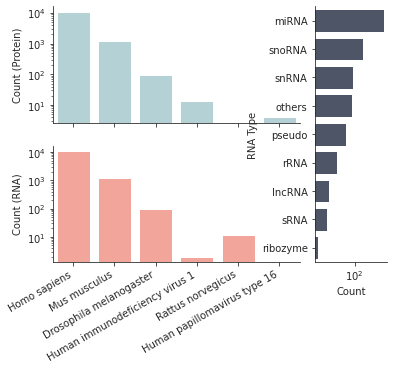

In [18]:
fig = plt.figure(constrained_layout = True, figsize = (6,4.7))

gs  = fig.add_gridspec(2,4)
ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[1,0:3])
ax3 = fig.add_subplot(gs[:,3])

RNA_COLOR      = '#4a536b'
SPECIES_COLOR1 = '#aed6dc'
SPECIES_COLOR2 = '#ff9a8d'

plot_most_common_species_freq(df, ax1, ax2, kwargs_0 = {'color' : COLOR1}, kwargs_1 = {'color' : COLOR2})

# Share x labels for RNA and protein species and rotate 30 degrees
plt.setp(ax1.get_xticklabels(), visible=False)

species = ax2.get_xticklabels()
species[3] = 'Human immunodeficiency virus type 1'

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')

plot_rna_type_frequency(df, ax3, color = RNA_COLOR)

sbn.despine()
#plt.tight_layout()

# This must have changed with an updated version of matplotlib. Just edit using PP
plt.savefig("Short_RNAInter_interactions_rna_type_dists_v2.png", dpi = 300)

### FIRE 

![](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12918-017-0390-8/MediaObjects/12918_2017_390_Fig3_HTML.gif?as=webp)

The procedure of our method FIRE is as follows:

1. Construct the positive set PS of PRIs based on the PRIDB and NPInter databases, and compute the similarity matrix SP of proteins involved in PS as in “Protein-protein similarity computation” section.
 
2. For protein $p_i$ and RNA $r_j$ that do not form a positive PRI in PS, i.e., ($p_i$ , $r_j$) ∉ PS, compute a score between $p_i$ and $r_j$ as follows:
    * If protein $p_k$ $(k≠i)$ and $r_j$ forms a PRI in the positive PRI set PS, then the score $SPR_{i,j,k}$ indicating the confidence of ($p_i$ , $r_j$) being a positive PRI via protein $p_k$ can be evaluated via $SP_{i,k}$, which is the similarity between $p_i$ and $p_k$.
    * As there may be multiple (say n) positive PRIs involving $r_j$ in PS, we aggregate the scores $SPR_{i,j,k}$ over all positive PRIs ($p_k$, $r_j$) ($k≠i$ and $k=1..n$) as follows:
    
        $$SPR_{i,j}=\sum_{k=1}^{n}SPR_{i,j,k}=\sum_{k=1}^{n}δ(k,j) × SP_{i,k}$$
        
    * $SPR_{i,j}$ indicates the confidence of ($p_i$ , $r_j$) being a positive PRI, $δ(i,j)=1$ if ($p_k$, $r_j$) is a positive PRI, otherwise 0.


3. As ($p_i$, $r_j$) ∉PS, it is a potential negative PRI. Sorting all generated potential PRIs ($p_i$, $r_j$) via their scores $SPR_{i,j}$ in increasing order, the top-m protein-RNA pairs in the sorted list are taken as negative PRIs if m negative PRIs are to be generated.


### Protein-protein similarity computation

We compute the similarity between any two proteins involved in the positive set based on three types of data sources: sequence information, functional annotations and protein domains, these computed similarities are called sequence similarity, functional annotation semantic similarity and protein domain similarity, which are merged to get the final similarity of the two proteins.

**Sequence similarity (SS)**. Protein sequences are obtained from the UniProt database [23]. We compute sequence similarity between two proteins using a **normalized version of Smith-Waterman score** [24]. The normalized Smith-Waterman score between two proteins $p_i$ and $p_j$ is:

$$nsw(p_i,p_j)=\frac{sw(p_i,p_j)}{\sqrt{sw(p_i,p_j)}\sqrt{sw(p_j,p_j)}}$$

where $sw(..,..)$ means the original Smith-Waterman score. By applying this operation to protein pair $p_i$ and $p_j$, we can obtain their sequence similarity $SS(p_i,p_j)=(nsw(p_i,p_j) + nsw(p_j ,p_i)) / 2$.

**Functional annotation semantic similarity (FS)**. GO annotations are downloaded from the **GO database** [25]. Semantic similarity between each pair of proteins is calculated based on the overlap of the GO terms associated with the two proteins [26]. All three types of GO are used in the computation as similar RNAs are expected to interact with proteins that act in similar biological processes, or have similar molecular functions or reside in similar cell compartments. We compute the Jaccard value [27] with respect to the GO terms of each pair of proteins as their similarity. The Jaccard score between term sets $p_j$ and $p_j$ of proteins $p_i$ and $p_j$ is defined as $|t_i ∩ t_j | / |t_i ∪ t_j |$, which is the ratio of the number of common terms between proteins $p_i$ and $p_j$ to the total number of terms of $p_i$ and $p_j$ , which is used as the functional annotation semantic similarity FS($p_i$ ,$p_j$ ) of proteins $p_i$ and $p_j$ .

**Protein domain similarity (DS)**. Protein domains are extracted from **Pfam database** [28]. Each protein is represented by a domain fingerprint (binary vector) whose elements encode the presence or absence of each retained Pfam domain by 1 or 0, respectively. We compute the Jaccard value of any two proteins $p_i$ and $p_j$ with their domain fingerprints as their similarity DS($p_i,p_j$).

For proteins $p_i$ and $p_j$ , we compute the aggregated similarity (AS) by merging the three different similarity measures above as follows:

$$AS(p_i,p_j)=(SS(p_i,p_j)+FS(p_i,p_j)+DS(p_i,p_j))/3$$

In [8]:
from Bio import SeqIO
import pandas as pd

from Utils.negative_sampling import Uniprot2GO, Uniprot2Domain

with open("../Data/RawData/uniprot_sprot.fasta") as handle:
    x = set([record.id.split('|')[1] for record in SeqIO.parse(handle, 'fasta')])

uniprot2domain = Uniprot2Domain(x,"../Data/OUTDATED/PfamScan/uniprot_sprot_domains.tsv")
uniprot2go = Uniprot2GO(x, '../Data/IdConverters/swissprot_go_terms.tab')

In [9]:
len(uniprot2domain.uniprot2domain)

310347

In [10]:
x = set(df['UniprotID'])
t = [uniprot2domain.uniprot2domain.get(i) for i in x]

rnainter_domain_counts = [len(i) if i else 0 for i in t]

# Percentage of unique RNAInter Uniprot IDs contain comain
pd.Series(rnainter_domain_counts).value_counts(normalize = True).round(3)

0    0.672
1    0.311
2    0.018
dtype: float64

blast all_v_all
```bash
makeblastdb -in <swissprot>.fasta -dbtype prot -out swissprot_db
blastp -db swissprot_db -query <swissprot>.fasta -outfmt 6 -out swissprot_all_v_all.tsv -num_threads 4
```

In [11]:
uniprot_ids = set(df['UniprotID'].dropna())
print(f"Number of unique protein ids: {len(uniprot_ids)}")

Number of unique protein ids: 338


In [12]:
# Can calculate for 1 sequence pair, now need to create DF

SIMILARITY_FRAME_PATH = "../Data/TrainingData/NegativeSamples/small_interaction_similarity_frame.csv"

from os import path

if not path.exists(SIMILARITY_FRAME_PATH):
    generator = FIREDataFrameGenerator(uniprot_ids, share_species = True)
    similarity_frame = generator.generate_similarity_df()
    similarity_frame.to_csv(SIMILARITY_FRAME_PATH, index = False)
else:
    similarity_frame = pd.read_csv(SIMILARITY_FRAME_PATH)

In [13]:
print(f"""
Proportion of 0 seq similarity: {round( sum((similarity_frame['seq_similarity'] == 0)) / len(similarity_frame), 3)}
Sequence similarity scores between 0.3 and 0.5: {sum( (similarity_frame['seq_similarity'] >= 0.30) & (similarity_frame['seq_similarity'] <= 0.5) )}
Sequence simialrity scores greater than 0.5: {sum(similarity_frame['seq_similarity'] > 0.5)}
""")


Proportion of 0 seq similarity: 0.989
Sequence similarity scores between 0.3 and 0.5: 29
Sequence simialrity scores greater than 0.5: 6



In [14]:
print(f"""
DISTRIBUTTION OF DOMAIN SIMILARITY SCORES:
---
{similarity_frame['domain_similarity'].value_counts(normalize=True)}
""")


DISTRIBUTTION OF DOMAIN SIMILARITY SCORES:
---
0.0    0.964243
1.0    0.034803
0.5    0.000954
Name: domain_similarity, dtype: float64



In [15]:
z = pd.concat([similarity_frame['uniprot1'],similarity_frame['uniprot2']])
t = [len(uniprot2go.uniprot2go.get(i)) for i in set(z)]

print(f"""
FUNCIONAL SIMILARITY REPORT
---
Proportion of 0 functional similarity: {round(sum(similarity_frame['func_similarity'] == 0)/len(similarity_frame),3)}
Distribution of GO term counts / RNAInter UniprotID: 

{pd.Series(t).value_counts().sort_index()}

Proportion of proteins with at least 10 GO terms: {round(sum(pd.Series(t).value_counts().sort_index()[9:]) / sum(pd.Series(t).value_counts().sort_index()),3)}
""")


FUNCIONAL SIMILARITY REPORT
---
Proportion of 0 functional similarity: 0.629
Distribution of GO term counts / RNAInter UniprotID: 

1      3
2      5
3      2
4      4
5      6
6      6
7      6
8      3
9      8
10     6
11    10
12     3
13     7
14     1
15     6
16     1
17     2
18     1
19     3
21     3
22     1
23     1
24     1
25     2
26     2
28     2
29     1
31     1
32     1
34     1
35     1
37     1
38     1
40     1
46     1
47     1
49     1
55     1
58     1
76     1
81     1
dtype: int64

Proportion of proteins with at least 10 GO terms: 0.609



In [16]:
print(f"""
FIRE SCORE REPORT
---
Proportion of 0 FIRE similarity: {round(sum(similarity_frame['similarity_score'] == 0) / len(similarity_frame),3)}
Proportion of 0.05 >= FIRE similarity: {round(sum((similarity_frame['similarity_score'] >= 0.01)) / len(similarity_frame),3)}
""")


FIRE SCORE REPORT
---
Proportion of 0 FIRE similarity: 0.629
Proportion of 0.05 >= FIRE similarity: 0.283



In [17]:
print(f"""
SPECIES ASSIGNMENT COUNT
---
{similarity_frame['species'].value_counts()}
""")


SPECIES ASSIGNMENT COUNT
---
Homo sapiens    4005
Mus musculus     190
Name: species, dtype: int64



In [18]:
print(f"Number of scored protein pairs: {len(similarity_frame)}")

Number of scored protein pairs: 4195


/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


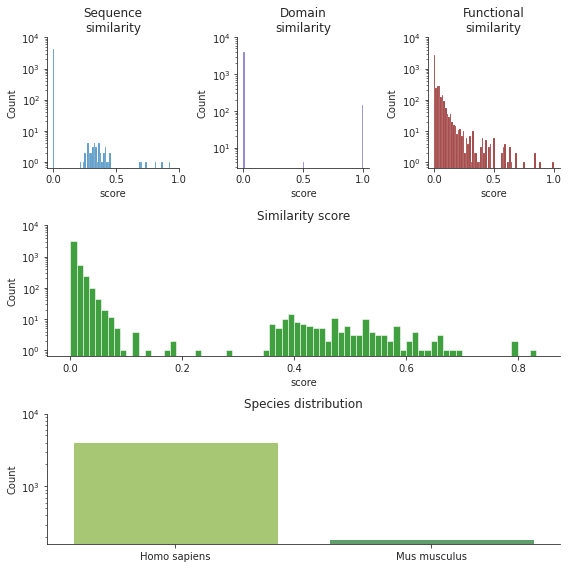

In [51]:
SAVE_FIG = True

# It's 8 instead of 6 because savefig doesn't respect figsize. 
# Outputs dimmensions ~6x6
fig = plt.figure(figsize = (8,8))
gs = fig.add_gridspec(3,3)

seq_score_ax      = fig.add_subplot(gs[0,0])
domain_score_ax   = fig.add_subplot(gs[0,1])
function_score_ax = fig.add_subplot(gs[0,2])
similartiy_ax     = fig.add_subplot(gs[1,:])
species_ax        = fig.add_subplot(gs[2,:])

sbn.histplot(similarity_frame['seq_similarity'], bins = 75, ax = seq_score_ax)
seq_score_ax.set_title("Sequence\nsimilarity")
seq_score_ax.set_yscale('log')
seq_score_ax.set_xlabel("score")
seq_score_ax.set_xticks([0,0.5,1])
seq_score_ax.set_ylim(None, 1e4)

sbn.histplot(similarity_frame['domain_similarity'], bins = 75, ax = domain_score_ax, color = 'slateblue')
domain_score_ax.set_title("Domain\nsimilarity")
domain_score_ax.set_yscale('log')
domain_score_ax.set_xlabel("score")
domain_score_ax.set_xticks([0,0.5,1])

domain_score_ax.set_ylim(None, 1e4)

sbn.histplot(similarity_frame['func_similarity'], bins = 75, ax = function_score_ax, color = 'maroon')
function_score_ax.set_title("Functional\nsimilarity")
function_score_ax.set_yscale('log')
function_score_ax.set_xlabel("score")
function_score_ax.set_xticks([0,0.5,1])

function_score_ax.set_ylim(None, 1e4)

sbn.histplot(similarity_frame['similarity_score'], bins = 75, ax = similartiy_ax, color = 'g')
similartiy_ax.set_title("Similarity score")
similartiy_ax.set_yscale('log')
similartiy_ax.set_xlabel("score")
similartiy_ax.set_ylim(None, 1e4)

# sbn.displot(similarity_frame['domain_similarity'], bins = 75, ax = axes[0,2])
# sbn.displot(similarity_frame['similarity_score'], bins = 75, ax = axes[1,0])

sbn.countplot(similarity_frame["species"], 
              order = similarity_frame["species"].value_counts().index,
              palette = 'summer_r',
              ax    = species_ax)

species_ax.set_title("Species distribution")
species_ax.set_yscale('log')
#species_ax.set_xticklabels(species_ax.get_xticklabels(), ha = "right")
species_ax.set_xlabel("")
species_ax.set_ylabel("Count")
species_ax.set_ylim(None, 1e4)

sbn.despine()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig("Similarity_score_and_subscore_distributions_current.png", dpi = 300, bbox_inches = 'tight')

# Do mutual interacting pairs contain high similarity scores?

In [19]:
def generate_rna2protein_pairs_dict(positive_samples_df : pd.DataFrame, 
                                    rna_id_col_name : str, prot_id_col_name : str) -> dict:
    """
    uses a dataframe and generates a dictionary that 
    returns all proteins that an RNA id interacts with. 
    
    example:
    >>> interaction_df = pd.DataFrame({'protein' : ['x','y','z','α'],
                                       'rna'     : ['a','a','b','c']})
    >>> generate_rna2protein_pairs_dict(interaction_df, "rna", "protein")
    {'a': ('x', 'y'), 'b': ('z',), 'c': ('α',)}
    """
    return positive_samples_df.groupby([rna_id_col_name]).aggregate(tuple).to_dict()[prot_id_col_name]

In [20]:
rna_id2protein_partners = generate_rna2protein_pairs_dict(df, 'RNA_Name', 'UniprotID')

# Filters out proteins RNAs with only 1 binding partner
rna_id2protein_partners = {rna : proteins for rna,proteins in rna_id2protein_partners.items() if len(proteins) > 1}

In [21]:
from itertools import combinations

def flatten(l : list) -> list:
    return [j for i in l for j in i]

unique_binding_pairs = set(flatten([list(combinations(partners, r = 2)) for partners in rna_id2protein_partners.values()]))

In [22]:
#unique_binding_pairs
fire_pairs        = zip(similarity_frame['uniprot1'], similarity_frame['uniprot2'])
positive_pair_idx, positive_pairs = zip(*[(n,pair) for n,pair in enumerate(fire_pairs) if pair in unique_binding_pairs or pair[::-1] in unique_binding_pairs])

/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 95.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 80.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


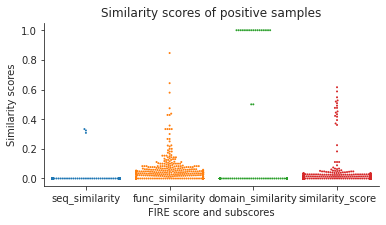

In [23]:
positive_pair_data = similarity_frame.iloc[list(positive_pair_idx), :]
score_cols         = ['seq_similarity','func_similarity','domain_similarity','similarity_score']
boxplot_data       = positive_pair_data[['seq_similarity','func_similarity','domain_similarity','similarity_score']].melt()

fig,ax = plt.subplots(figsize=(6,3))

sbn.swarmplot(x = 'variable', y = 'value', data = boxplot_data, s = 2, edgecolor = None)
# sbn.boxplot(x = 'variable', y = 'value', data = boxplot_data)
ax.set_ylabel("Similarity scores")
ax.set_xlabel("FIRE score and subscores")
# ax.set_xticks([0,1,2,3], ['Sequence','Function','Domain','Overall'])
ax.set_title("Similarity scores of positive samples")
sbn.despine()

#plt.savefig("FIRE_scores_for_positive_samples.png")

In [24]:
positive_pairs

(('P35754', 'P14854'),
 ('P35754', 'Q3ZAQ7'),
 ('Q9JHY3', 'Q61012'),
 ('P63167', 'P29034'),
 ('Q9JHY3', 'P62806'),
 ('P50150', 'Q8N6N7'),
 ('P50150', 'Q9Y333'),
 ('P50150', 'P14854'),
 ('P50150', 'Q5TGZ0'),
 ('P02795', 'P33552'),
 ('P02795', 'P14854'),
 ('P50150', 'Q49B96'),
 ('P18077', 'P14854'),
 ('P18077', 'Q3ZAQ7'),
 ('P18077', 'Q5TGZ0'),
 ('Q96FJ2', 'P14854'),
 ('Q96FJ2', 'Q3ZAQ7'),
 ('Q96FJ2', 'Q9Y5J9'),
 ('Q96FJ2', 'Q5TGZ0'),
 ('Q96FJ2', 'Q9Y5L4'),
 ('Q96FJ2', 'Q8NG35'),
 ('Q96FJ2', 'Q9P0J6'),
 ('Q96FJ2', 'Q9Y5J6'),
 ('Q96FJ2', 'O00626'),
 ('P18077', 'Q13296'),
 ('P18077', 'Q8N6N7'),
 ('Q13296', 'P62942'),
 ('P18077', 'P13501'),
 ('P18077', 'O00626'),
 ('Q13296', 'Q9BTM9'),
 ('Q13296', 'O75347'),
 ('Q13296', 'O00244'),
 ('Q13296', 'P14854'),
 ('P50150', 'Q9BZL1'),
 ('Q9Y333', 'P51671'),
 ('Q9Y333', 'Q5TGZ0'),
 ('Q9Y333', 'Q9P0J6'),
 ('Q9Y333', 'O00626'),
 ('P63168', 'Q61012'),
 ('P63168', 'P63213'),
 ('Q9Y333', 'P14854'),
 ('Q9NZ45', 'O95777'),
 ('P62806', 'Q61012'),
 ('P62806',

In [25]:
id2seq = dict(zip(df['UniprotID'], df['proteins']))

In [26]:
seq1, seq2 = zip(*[(id2seq[uniprot1],id2seq[uniprot2]) for uniprot1, uniprot2 in positive_pairs])
# seq2 = similarity_frame['uniprot2'].apply(lambda x: id2seq[x])

processed_seq1 = [' '.join(seq) for seq in seq1]
processed_seq2 = [' '.join(seq) for seq in seq2]

In [27]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

In [28]:
CHUNKSIZE = 10
x_data = IterableProteinEmbedding(processed_seq1, tokenizer, model, CHUNKSIZE, max_len = 110, cuda = True)
y_data = IterableProteinEmbedding(processed_seq2, tokenizer, model, CHUNKSIZE, max_len = 110, cuda = True)

In [29]:
import torch

x_tensor          = torch.cat([i for i in x_data])
SHAPE             = len(processed_seq1)
x_tensor_reshaped = x_tensor.reshape(SHAPE, 1024)

  0%|          | 0/74 [00:00<?, ?it/s]

In [30]:
x_tensor_reshaped

tensor([[ 0.0314, -0.0035, -0.0010,  ..., -0.0100,  0.0008,  0.0172],
        [ 0.0314, -0.0035, -0.0010,  ..., -0.0100,  0.0008,  0.0172],
        [ 0.0433,  0.0304,  0.0509,  ..., -0.0440, -0.0357, -0.0307],
        ...,
        [ 0.0320, -0.0031,  0.0118,  ..., -0.0304, -0.0398,  0.0087],
        [ 0.0447, -0.0102,  0.0595,  ..., -0.0157, -0.0484, -0.0033],
        [-0.0003, -0.0456,  0.0263,  ..., -0.0443, -0.0587,  0.0242]],
       device='cuda:0')

In [31]:
y_tensor          = torch.cat([i for i in y_data])
SHAPE             = len(processed_seq2)
y_tensor_reshaped = y_tensor.reshape(SHAPE, 1024)

  0%|          | 0/74 [00:00<?, ?it/s]

In [32]:
y_tensor_reshaped

tensor([[-0.0017,  0.0028, -0.0223,  ..., -0.0090, -0.0360, -0.0057],
        [-0.0433, -0.0651,  0.0097,  ..., -0.0117, -0.0190, -0.0084],
        [ 0.0271,  0.0086,  0.0038,  ..., -0.0232, -0.0154, -0.0150],
        ...,
        [ 0.0091, -0.0201,  0.0179,  ..., -0.0258, -0.0319, -0.0054],
        [ 0.0028,  0.0207,  0.0464,  ..., -0.0222, -0.0184, -0.0132],
        [-0.0082, -0.0457,  0.0180,  ..., -0.0424, -0.0741,  0.0270]],
       device='cuda:0')

In [33]:
# import sys

# unrefined_sae = torch.load("../Data/EncodedData/BERT_Swiss_unrefined_SAE.pt")
# refined_sae   = torch.load("../Data/EncodedData/BERT_Swiss_refined_SAE.pt")

sae = torch.load("ProtBERT_encoded_110_swissprot_DenseSAE.pt")

In [34]:
sae.train_step = 0
sae.eval();

positive_diff_matrix = sae(x_tensor_reshaped) - sae(y_tensor_reshaped)

# refined_sae.train_step = 0
# refined_sae.eval();

# refined_diff_matrix   = refined_sae(x_tensor_reshaped) - refined_sae(y_tensor_reshaped)

In [35]:
sae.train_step = 0
sae.eval();

positive_diff_magnitude = magnitude(sae(x_tensor_reshaped) - sae(y_tensor_reshaped))

/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 96.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 72.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 94.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bobby/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 84.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


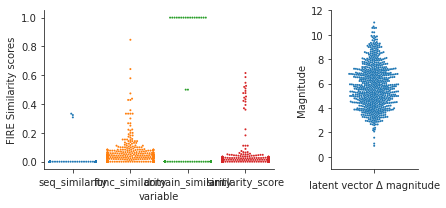

In [36]:
# wtf
# from matplotlib import gridspec as gs

fig = plt.figure(figsize=(6,3))
gs = fig.add_gridspec(1,3)

fire_ax = fig.add_subplot(gs[:2])
diff_ax = fig.add_subplot(gs[-1])

positive_pair_data = similarity_frame.iloc[list(positive_pair_idx), :]
score_cols         = ['seq_similarity','func_similarity','domain_similarity','similarity_score']
boxplot_data       = positive_pair_data[['seq_similarity','func_similarity','domain_similarity','similarity_score']].melt()

sbn.swarmplot(x = 'variable', y = 'value', data = boxplot_data, s = 2, edgecolor = None, ax = fire_ax)

# sbn.boxplot(x = 'variable', y = 'value', data = boxplot_data)
fire_ax.set_ylabel("FIRE Similarity scores")

# fire_ax.set_xlabel("FIRE score and subscores")
# ax.set_xticks([0,1,2,3], ['Sequence','Function','Domain','Overall'])
# fire_ax.set_title("Similarity scores of positive samples")
sbn.despine()

sbn.swarmplot(y = positive_diff_magnitude.cpu(), s = 2, ax = diff_ax)

diff_ax.set_xlabel("latent vector Δ magnitude")
diff_ax.set_ylabel("Magnitude")
diff_ax.set_ylim(-1,12)

plt.tight_layout()
sbn.despine()

plt.savefig("Positive_sample_FIRE_and_SAE_similarities.png", dpi = 300)

In [49]:
print(f"""Mutual interaction pair FIRE report:
---
Sequence similarity below 0.1: {sum(positive_pair_data['seq_similarity'] < 0.1) / len(positive_pair_data)}
FIRE similarity below 0.1: {sum(positive_pair_data['similarity_score'] < 0.1) / len(positive_pair_data)}""")

Mutual interaction pair FIRE report:
---
Sequence similarity below 0.1: 0.9959072305593452
FIRE similarity below 0.1: 0.9699863574351978


In [53]:
print(f"""Mutual interaction pair SAE-difference report:
---
{pd.Series(positive_diff_magnitude.cpu()).describe()}""")

Mutual interaction pair SAE-difference report:
---
count    733.000000
mean       5.789636
std        1.758968
min        0.894959
25%        4.463973
50%        5.666668
75%        6.956232
max       11.007896
dtype: float64


# Generate negative samples

In [64]:
from Utils.negative_sampling import FIRE

In [65]:
PROTEIN_INFO_COLS = ['Protein_name','NCBI_GeneID','Protein_Type','Also_species','proteins','UniprotID']

fire = FIRE(similarity_frame,
            protein_info_cols    = PROTEIN_INFO_COLS,
            seed                 = 255,
            max_samples_per_pair = None)

negative_samples = fire.generate_negative_samples(df)

/home/bobby/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


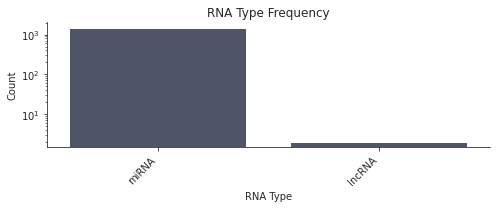

In [66]:
###########################################
# Unique RNA and Protein Types
###########################################

fig, ax = plt.subplots(1,1, figsize = (7,3))

# Create dataframes containing all unique RNAs/Proteins and their types
unique_rna_df     = negative_samples.groupby(['RNA_Name','RNA_type']).size().reset_index()
unique_protein_df = negative_samples.groupby(['Protein_name','Protein_Type']).size().reset_index()

###

PALETTE = sbn.color_palette("Purples_r", 9)
COLOR   = '#4a536b'

sbn.countplot(x = 'RNA_type', 
              data = unique_rna_df,
              #palette = PALETTE,
              color = COLOR,
              order = unique_rna_df.RNA_type.value_counts().index,
              ax = ax)

ax.set_title("RNA Type Frequency")
ax.set_yscale('log')
ax.set_xlabel('RNA Type')
ax.set_ylabel('Count')

plt.xticks(rotation = 45, ha = 'right')

sbn.despine()

plt.tight_layout()
#plt.savefig("RNA_types_0.5_confidence.png", dpi = 300, transparent=True)

In [67]:
negative_samples['Also_species'].value_counts()

Homo sapiens    11942
Mus musculus      219
Name: Also_species, dtype: int64

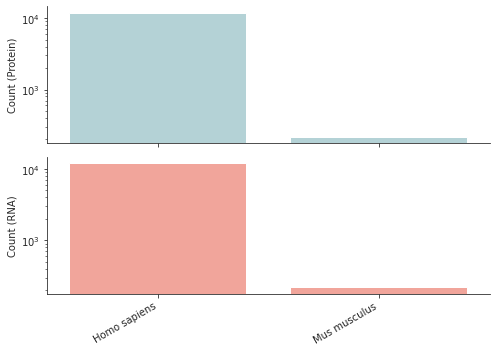

In [68]:
most_common_species = pd.concat((negative_samples['Species'], negative_samples['Also_species'])).value_counts().index


fig, axes = plt.subplots(2,1, figsize = (7,5), sharex = True)

most_common_species_df = negative_samples[negative_samples['Also_species'].isin(most_common_species) & negative_samples['Species'].isin(most_common_species)]

COLOR1 = '#aed6dc'
COLOR2 = '#ff9a8d'

sbn.countplot(x = "Also_species", 
              data = most_common_species_df,
              color = COLOR1,
              order = most_common_species,
              ax = axes[0])

axes[0].set_xlabel('')
axes[0].set_yscale('log')
axes[0].set_ylabel('Count (Protein)')

sbn.countplot(x = "Species",
              data = most_common_species_df,
              color = COLOR2,
              order = most_common_species,
              ax = axes[1])

axes[1].set_yscale('log')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count (RNA)')

plt.xticks(rotation=30, ha = 'right')

sbn.despine()

plt.tight_layout()

In [69]:
training_data = pd.concat((df, negative_samples))
training_data.index = pd.RangeIndex(len(training_data))
training_data

,index,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA,1
1,911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT,1
2,912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA,1
3,912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
4,2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24317,6213281,RP07838819,hsa-miR-4697-5p,MIMAT0019791,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,AGGGGGCGCAGUCACUGACGUG,0
24318,6213282,RP07838820,hsa-miR-4488,MIMAT0019022,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,AGGGGGCGGGCUCCGGCG,0
24319,6213283,RP07838821,hsa-miR-1237-5p,MIMAT0022946,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,CGGGGGCGGGGCCGAAGCGCG,0
24320,6213284,RP07838822,hsa-miR-6798-5p,MIMAT0027496,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,CCAGGGGGAUGGGCGAGCUUGGG,0


In [70]:
SAVEDATA = True

if SAVEDATA:
    # ignore index_col
    training_data.to_csv("../Data/RNAInter_small_interaction_fire_training_data_current.csv", index = False)

In [71]:
24322 /2

12161.0

In [72]:
#set(df.UniprotID)

In [73]:
# This test works

# fire2 = FIRE(similarity_frame,
#              protein_info_cols    = PROTEIN_INFO_COLS,
#              seed                 = 255,
#              max_samples_per_pair = 2)

In [74]:
#fire2.create_negative_samples("P24928", "Q15797", positive_df)

In [75]:
df.head()

,index,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA,1
1,911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT,1
2,912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA,1
3,912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
4,2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1


In [24]:
from Utils.train_utils import MutualDataRemover

In [25]:
class MutualDataRemover:
    """
    class designed to find any mutual entries found in two
    different datasets. Mutual entries are defined by shared 
    ids -- most likely a shared RNA and protein ID or sequence. 
    User must specifify columns names to search.
    
    Once found, MutualDataRemover returns the training set without
    any entries found in the evaluation set
    
    Its primary use the remove_mutual_entries_from_training function.
    This inputs a training and evaluation dataset and returns a 
    training dataset pruned of any mutual entries. But this is also
    used to remove any mutually found protein pairs for negative
    sampling. 
    """
    
    def __init__(self, col_names : list or tuple):
        self.col_names = col_names
        
    def generate_pairs(self, data : pd.DataFrame) -> zip:
        return zip(*[data[col] for col in self.col_names])
    
    def find_parsed_idx(self, train_pairs : zip, eval_pair_set : set) -> list:
        return [n for n,pair in enumerate(train_pairs) if pair not in eval_pair_set]
    
    def remove_mutual_entries_from_training(self, training_data : pd.DataFrame, 
                                            evaluation_data : pd.DataFrame) -> pd.DataFrame:
        
        train_pairs    = list(self.generate_pairs(training_data))
        eval_pair_set  = set(self.generate_pairs(evaluation_data))
        
        parsed_train_idx = self.find_parsed_idx(train_pairs, eval_pair_set)
        
        parsed_training_data = train.iloc[parsed_train_idx, :].reset_index(drop=True)
        
        return parsed_training_data

In [26]:
class InteractionSwapper:
    """
    Class designed to swap RNA interactions of two protein pairs. 
    These are treated as negative samples for future training. 
    """
    
    def __init__(self, prot_id_col : str,
                 prot_info_cols : list,
                 interaction_col_name : str,
                 seed : int = 255, 
                 max_interactions_per_pair : int = 2):
        
        self.prot_id_col               = prot_id_col
        self.prot_info_cols            = prot_info_cols
        self.interaction_col_name      = interaction_col_name
        self.seed                      = seed
        self.max_interactions_per_pair = max_interactions_per_pair
        
    def _isolate_protein_interactions(self, proteinid, interaction_df):
        """
        
        """
        
        interaction_block = interaction_df[(interaction_df[self.prot_id_col] == proteinid)]
        return interaction_block
    
    def _swap_protein_info(self, unswapped_block1, unswapped_block2):
        """
        """
        
        self.prot_info_cols.append(self.prot_id_col)
        
        ################ THIS IS AN ISSUE
        unswapped_block1_info = unswapped_block1[self.prot_info_cols].values[0]
        unswapped_block2_info = unswapped_block2[self.prot_info_cols].values[0]

        # swap the interactions in these two blocks
        unswapped_block1.loc[:,self.prot_info_cols] = unswapped_block2_info
        unswapped_block2.loc[:,self.prot_info_cols] = unswapped_block1_info
        
        # renname variables to avoid confusion. Reset the index for
        # proper interleaving in future function
        swapped_block1 = unswapped_block1.reset_index(drop=True)
        swapped_block2 = unswapped_block2.reset_index(drop=True)
        
        return swapped_block1, swapped_block2
     
    def _shuffle_rows(self, block):
        "Shuffles the rows in a interaction block and resets index"
        return block.sample(frac=1, random_state = self.seed).reset_index(drop=True)
    
    def _interleave_block_rows(self, swapped_block1 : pd.DataFrame, swapped_block2 : pd.DataFrame) -> pd.DataFrame:
        """
        Takes two interaction blocks and interleaves the entries together into a combined interation block.
        
        These are interleaved so that sampling from the block results in a near equal draw from both protein
        interactions
        """
        
        return pd.concat([swapped_block1, swapped_block2]).sort_index().reset_index(drop=True)

    def _trim_excess_swapped_samples(self, interleaved_swapped_blocks):
        ""
        return interleaved_swapped_blocks.iloc[:self.max_interactions_per_pair]
    
    def swap_interaction(self, protein_id1 : str, protein_id2 : str, 
                         interaction_df : pd.DataFrame):
        """
        
        """
        unswapped_block1 = self._isolate_protein_interactions(protein_id1, interaction_df)
        unswapped_block2 = self._isolate_protein_interactions(protein_id2, interaction_df)
        
        swapped_block1, swapped_block2 = self._swap_protein_info(unswapped_block1, unswapped_block2)
        
        shuffled_swapped_block1 = self._shuffle_rows(swapped_block1)
        shuffled_swapped_block2 = self._shuffle_rows(swapped_block2)
        
        interleaved_blocks = self._interleave_block_rows(shuffled_swapped_block1, shuffled_swapped_block2)
        
        negative_samples = self._trim_excess_swapped_samples(interleaved_blocks)
        
        negative_samples[self.interaction_col_name] = 0
        
        return negative_samples
    
    def swap_interactions(self, protein_ids1 : list, protein_ids2 : list, 
                          interaction_df : pd.DataFrame,
                          total_samples_generated : int) -> pd.DataFrame:
        """
        Performs "swap interaction" on all 
        """
        
        negative_sample_blocks = [self.swap_interaction(protein_id1, protein_id2, interaction_df) for protein_id1, protein_id2 
                                  in zip(protein_ids1, protein_ids2)]
        
        negative_df = pd.concat(negative_sample_blocks).reset_index(drop=True)
        negative_df = negative_df[:total_samples_generated]
        
        return negative_df

In [29]:
ids1 = ["Q15651","P61956"]
ids2 = ["P04608","P04608"]

prot_id_col    = "UniprotID"
prot_info_cols = ["Protein_name", "Protein_Type", "Also_species", "proteins"]

swapper = InteractionSwapper(prot_id_col, prot_info_cols, interaction_col_name = "interacts")

swapper.swap_interactions(ids1, ids2, df, total_samples_generated = 20)

/home/robertlink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
<ipython-input-26-3dd2f106979b>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_samples[self.interaction_col_name] = 0


,index,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,4105865,RP04395111,hsa-let-7e,MI0000066,miRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG,0
1,8923246,RP33979112,hiv1-miR-TAR-3p,MIMAT0006017,miRNA,Human immunodeficiency virus 1,HMGN3,155871.0,TF,Homo sapiens,0.9975,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,UCUCUGGCUAACUAGGGAACCCA,0
2,8882336,RP33933489,hsa-mir-4787,MI0017434,miRNA,Homo sapiens,tat,6613.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,CGGUCCAGACGUGGCGGGGGUGGCGGCGGCAUCCCGGACGGCCUGUGAGGGAUGCGCCGCCCACUGCCCCGCGCCGCCUGACCG,0
3,8923246,RP33979112,hiv1-miR-TAR-3p,MIMAT0006017,miRNA,Human immunodeficiency virus 1,SUMO2,155871.0,TF,Homo sapiens,0.9975,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,UCUCUGGCUAACUAGGGAACCCA,0


In [74]:
prot_info_cols = ["Protein_name", "Protein_Type", "Also_species", "proteins", "UniprotID"]

display(block1.head())
display(block2.head())

block1_info = block1[prot_info_cols].values[0]
block2_info = block2[prot_info_cols].values[0]

block1.loc[:,prot_info_cols] = block2_info
block2.loc[:,prot_info_cols] = block1_info

display(block1.head())
display(block2.head())

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGC...,1
911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTG...,1
912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAA...,1
912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1
4105861,RP04395107,hsa-let-7a-1,MI0000060,miRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,1


,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
8923212,RP33979063,rno-let-7b-5p,MIMAT0000775,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UGAGGUAGUAGGUUGUGUGGUU,1
8923213,RP33979064,rno-let-7c-5p,MIMAT0000776,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UGAGGUAGUAGGUUGUAUGGUU,1
8923214,RP33979065,rno-let-7e-5p,MIMAT0000777,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UGAGGUAGGAGGUUGUAUAGUU,1
8923215,RP33979066,rno-let-7f-5p,MIMAT0000778,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UGAGGUAGUAGAUUGUAUAGUU,1
8923216,RP33979067,rno-miR-25-3p,MIMAT0000795,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,CAUUGCACUUGUCUCGGUCUGA,1


/home/robertlink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGC...,1
911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTG...,1
912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAA...,1
912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...,1
4105861,RP04395107,hsa-let-7a-1,MI0000060,miRNA,Homo sapiens,tat,9324.0,protein,Human immunodeficiency virus 1,0.5117,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,1


,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
8923212,RP33979063,rno-let-7b-5p,MIMAT0000775,miRNA,Rattus norvegicus,HMGN3,155871.0,TF,Homo sapiens,0.9768,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,UGAGGUAGUAGGUUGUGUGGUU,1
8923213,RP33979064,rno-let-7c-5p,MIMAT0000776,miRNA,Rattus norvegicus,HMGN3,155871.0,TF,Homo sapiens,0.9768,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,UGAGGUAGUAGGUUGUAUGGUU,1
8923214,RP33979065,rno-let-7e-5p,MIMAT0000777,miRNA,Rattus norvegicus,HMGN3,155871.0,TF,Homo sapiens,0.9768,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,UGAGGUAGGAGGUUGUAUAGUU,1
8923215,RP33979066,rno-let-7f-5p,MIMAT0000778,miRNA,Rattus norvegicus,HMGN3,155871.0,TF,Homo sapiens,0.9768,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,UGAGGUAGUAGAUUGUAUAGUU,1
8923216,RP33979067,rno-miR-25-3p,MIMAT0000795,miRNA,Rattus norvegicus,HMGN3,155871.0,TF,Homo sapiens,0.9768,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CAUUGCACUUGUCUCGGUCUGA,1


In [41]:
display(df)

shuffled_df = df.sample(frac=1, random_state = 255).reset_index(drop=True)
shuffled_df

display(shuffled_df)

df2 = pd.DataFrame({"A":['a','b','c'],
                    "B":['x','y','z']})

display(df2)

shuffled_df2 = df2.sample(frac=1, random_state = 255).reset_index(drop=True)
shuffled_df2

,A,B
0,1,4
1,2,5
2,3,6


,A,B
0,1,4
1,3,6
2,2,5


,A,B
0,a,x
1,b,y
2,c,z


,A,B
0,a,x
1,c,z
2,b,y


In [42]:
concat_df = pd.concat([shuffled_df, shuffled_df2]).sort_index().reset_index(drop=True)
concat_df

,A,B
0,1,4
1,a,x
2,3,6
3,c,z
4,2,5
5,b,y


In [36]:
# ONLY USED SWAPPED BLOCKS DURING TESTING

# positive_df = df
# uniprot_id1, uniprot_id2 = "P24928", "Q15797"
# max_samples_per_pair = 2
# ##############################################################

# uniprot1_block = positive_df[(positive_df['UniprotID'] == uniprot_id1)]
# uniprot2_block = positive_df[(positive_df['UniprotID'] == uniprot_id2)]

# swapped_block1 = uniprot1_block.copy()
# swapped_block2 = uniprot2_block.copy()

# # Isolate protein info
# PROTEIN_INFO_COLS = ['Protein_name','NCBI_GeneID','Protein_Type','Also_species','proteins','UniprotID']

# block_1_info = uniprot1_block[PROTEIN_INFO_COLS].iloc[0].values
# block_2_info = uniprot2_block[PROTEIN_INFO_COLS].iloc[0].values

# # Swap protein info
# swapped_block1.loc[:,PROTEIN_INFO_COLS] = block_2_info
# swapped_block2.loc[:,PROTEIN_INFO_COLS] = block_1_info

# # uniprot2_block
# # # Combine blocks
# swapped_block = pd.concat([swapped_block1.iloc[:max_samples_per_pair,:], 
#                             swapped_block2.iloc[:max_samples_per_pair,:]], axis = 0)

In [37]:
def only_protein_info_is_swapped(original_blocks: list, new_blocks: list, prot_info_cols):
    """
    Expereimnt test
    ---
    
    """
    
    assert len(original_blocks) and len(new_blocks) == 2
    
    # Protein values from block 1 were properly transfered into block2
    print(((original_blocks[0][PROTEIN_INFO_COLS].iloc[0].values == new_blocks[1][PROTEIN_INFO_COLS].iloc[0].values)).all())
    
    # Protein values from block 2 were properly transfered into block1
    print(((original_blocks[1][PROTEIN_INFO_COLS].iloc[0].values == new_blocks[0][PROTEIN_INFO_COLS].iloc[0].values)).all())
        
    # No other values within block 1 were modified from transfer
    print((original_blocks[0].drop(PROTEIN_INFO_COLS, axis=1).values == new_blocks[0].drop(PROTEIN_INFO_COLS, axis=1).values).all())
    
    # No other values within block 2 were modified from transfer
    print((original_blocks[1].drop(PROTEIN_INFO_COLS, axis=1).values == new_blocks[1].drop(PROTEIN_INFO_COLS, axis=1).values).all())

In [38]:
# # All checks are passed
# only_protein_info_is_swapped(original_blocks = [uniprot1_block,uniprot2_block], 
#                              new_blocks      = [swapped_block1,swapped_block2], 
#                              prot_info_cols  = PROTEIN_INFO_COLS)

# Negative Samples

In [76]:
# import sys
# sys.path.append("/home/robertlink/Thesis_work")

# from Utils.encoders import SkipGramEmbedder
# from itertools import combinations
# from gensim.models.callbacks import CallbackAny2Vec
# import pandas as pd

In [76]:
small_interactions = pd.read_csv("../Data/TrainingData/RNAInter_small_interaction_fire_training_data_current.csv")

In [77]:
small_interactions.tail()

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
24317,RP07838819,hsa-miR-4697-5p,MIMAT0019791,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,AGGGGGCGCAGUCACUGACGUG,0
24318,RP07838820,hsa-miR-4488,MIMAT0019022,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,AGGGGGCGGGCUCCGGCG,0
24319,RP07838821,hsa-miR-1237-5p,MIMAT0022946,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,CGGGGGCGGGGCCGAAGCGCG,0
24320,RP07838822,hsa-miR-6798-5p,MIMAT0027496,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,CCAGGGGGAUGGGCGAGCUUGGG,0
24321,RP07838823,hsa-miR-6805-5p,MIMAT0027510,miRNA,Homo sapiens,LSM2,57819.0,protein,Homo sapiens,0.5117,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,Q9Y333,UAGGGGGCGGCUUGUGGAGUGU,0


In [78]:
len(small_interactions)

24322

In [79]:
id2seq = dict(zip(small_interactions['UniprotID'], small_interactions['proteins']))

In [80]:
similarity_frame.head()
len(similarity_frame)

4195

In [81]:
seq1 = similarity_frame['uniprot1'].apply(lambda x: id2seq[x])
seq2 = similarity_frame['uniprot2'].apply(lambda x: id2seq[x])

In [82]:
seq1

0                                                              MEKVQYLTRSAIRRASTIEMPQQARQNLQNLFINFCLILICLLLICIIVMLL
1                             MWPNSILVLMTLLISSTLVTGGGVKGEEKRVCPPDYVRCIRQDDPQCYSDNDCGDQEICCFWQCGFKCVLPVKDNSEEQIPQSKV
2        MAQEFVNCKIQPGKVVVFIKPTCPYCRRAQEILSQLPIKQGLLEFVDITATNHTNEIQDYLQQLTGARTVPRVFIGKDCIGGCSDLVSLQQSGELLTRLKQIGALQ
3        MAQEFVNCKIQPGKVVVFIKPTCPYCRRAQEILSQLPIKQGLLEFVDITATNHTNEIQDYLQQLTGARTVPRVFIGKDCIGGCSDLVSLQQSGELLTRLKQIGALQ
4        MAQEFVNCKIQPGKVVVFIKPTCPYCRRAQEILSQLPIKQGLLEFVDITATNHTNEIQDYLQQLTGARTVPRVFIGKDCIGGCSDLVSLQQSGELLTRLKQIGALQ
                                                           ...                                                     
4190            MKVSAALLCLLLIAATFIPQGLAQPDAINAPVTCCYNFTNRKISVQRLASYRRITSSKCPKEAVIFKTIVAKEICADPKQKWVQDSMDHLDKQTQTPKT
4191              MKVSAALLWLLLIAAAFSPQGLAGPASVPTTCCFNLANRKIPLQRLESYRRITSGKCPQKAVIFKTKLAKDICADPKKKWVQDSMKYLDQKSPTPKP
4192    MARAALSAAPSNPRLLRVALLLLLLVAAGRRAAGASVATELRCQCLQTLQGIHPKNIQSVNVKS

In [83]:
# class LossLogger(CallbackAny2Vec):
#     """
#     Callback to print and store train/val loss. Val loss isn't
#     calculated by default, so let's fix that. 
#     """
#     # val_dataset, loss_function
#     def __init__(self):
#         self.current_epoch = 0
        
#         #self.val_set  = val
#         #self.loss     = val_loss
        
#         self.epochs     = list()
#         self.train_loss = list()
#         self.val_loss   = list()
        
#     def on_epoch_end(self, model):
        
#         loss = model.get_latest_training_loss()
        
#         if self.current_epoch == 0:
#             print(f'Loss after epoch {self.current_epoch}: {loss}')
#             # print(self.loss(model(self.val_set), self.val_set))
#             self.train_loss.append(loss)
#         else:
#             mod_loss = loss - self.loss_previous_step
#             print(f'Loss after epoch {self.current_epoch}: {mod_loss}')
#             self.train_loss.append(mod_loss)
            
#         self.loss_previous_step = loss
#         self.epochs.append(self.current_epoch)
#         self.current_epoch += 1

In [84]:
# SKIPGRAMPATH = '/home/robertlink/Thesis_work/Chapter_4/Notebooks/Prot2Vec_current.model'
# dense_embedder = SkipGramEmbedder(SKIPGRAMPATH, reduce = True)
# conv_embedder  = SkipGramEmbedder(SKIPGRAMPATH, reduce = False)

In [85]:
from transformers import AutoTokenizer, AutoModel

In [86]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

In [87]:
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

In [88]:
processed_seq1 = list(seq1.str.join(' '))
processed_seq2 = list(seq2.str.join(' '))

In [89]:
from Utils.negative_sampling import IterableProteinEmbedding

In [90]:
CHUNKSIZE = 10
x_data = IterableProteinEmbedding(processed_seq1, tokenizer, model, CHUNKSIZE, max_len = 110, cuda = True)
y_data = IterableProteinEmbedding(processed_seq2, tokenizer, model, CHUNKSIZE, max_len = 110, cuda = True)

In [91]:
import torch

x_tensor          = torch.cat([i for i in x_data])
SHAPE             = len(processed_seq1)
x_tensor_reshaped = x_tensor.reshape(SHAPE, 1024)

  0%|          | 0/420 [00:00<?, ?it/s]

In [92]:
x_tensor.shape

torch.Size([4195, 1024])

In [93]:
y_tensor          = torch.cat([i for i in y_data])
SHAPE             = len(processed_seq2)
y_tensor_reshaped = y_tensor.reshape(SHAPE, 1024)

  0%|          | 0/420 [00:00<?, ?it/s]

In [94]:
# import sys

# unrefined_sae = torch.load("../Data/EncodedData/BERT_Swiss_unrefined_SAE.pt")
# refined_sae   = torch.load("../Data/EncodedData/BERT_Swiss_refined_SAE.pt")

sae = torch.load("ProtBERT_encoded_110_swissprot_DenseSAE.pt")

In [95]:
sae.train_step = 0
sae.eval();

fire_diff_matrix = sae(x_tensor_reshaped) - sae(y_tensor_reshaped)

# refined_sae.train_step = 0
# refined_sae.eval();

# refined_diff_matrix   = refined_sae(x_tensor_reshaped) - refined_sae(y_tensor_reshaped)

In [96]:
# from cuml import UMAP
from umap import UMAP

# reduced_unrefined_diff_matrix = UMAP(random_state=255).fit_transform(unrefined_diff_matrix.cpu().numpy())
# reduced_refined_diff_matrix   = UMAP(random_state=255).fit_transform(refined_diff_matrix.cpu().numpy())

reduced_fire_diff_matrix = UMAP(random_state=255).fit_transform(fire_diff_matrix.cpu().numpy())

/home/bobby/.local/lib/python3.8/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [97]:
similarity_frame.head()

,uniprot1,uniprot2,seq_similarity,func_similarity,domain_similarity,similarity_score,species
0,P61014,Q30KN4,0.0,0.0,0.0,0.0,Mus musculus
1,Q9JHY3,P63213,0.0,0.0,0.0,0.0,Mus musculus
2,P35754,Q8N6N7,0.0,0.0,0.0,0.0,Homo sapiens
3,P35754,Q9NZ45,0.0,0.0,0.0,0.0,Homo sapiens
4,P35754,O14625,0.0,0.0,0.0,0.0,Homo sapiens


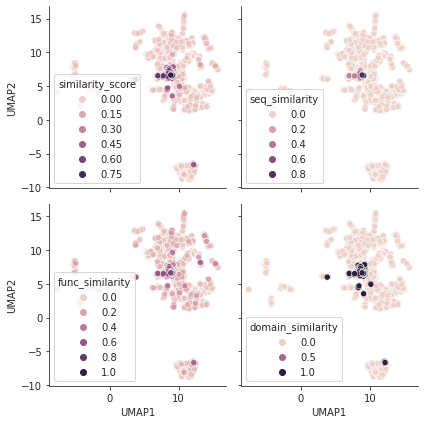

In [98]:
import seaborn as sbn

fig, axes = plt.subplots(2,2,figsize = (6,6), sharey = True, sharex = True)

sbn.scatterplot(x = reduced_fire_diff_matrix[:,0],
                y = reduced_fire_diff_matrix[:,1],
                hue = similarity_frame['similarity_score'],
                ax = axes[0,0])

axes[0,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')

sbn.scatterplot(x = reduced_fire_diff_matrix[:,0],
                y = reduced_fire_diff_matrix[:,1],
                hue = similarity_frame['seq_similarity'],
                ax = axes[0,1])

axes[0,1].set_xlabel('UMAP1')
axes[0,1].set_ylabel('UMAP2')

sbn.scatterplot(x = reduced_fire_diff_matrix[:,0],
                y = reduced_fire_diff_matrix[:,1],
                hue = similarity_frame['func_similarity'],
                ax = axes[1,0])

axes[1,0].set_xlabel('UMAP1')
axes[1,0].set_ylabel('UMAP2')

sbn.scatterplot(x = reduced_fire_diff_matrix[:,0],
                y = reduced_fire_diff_matrix[:,1],
                hue = similarity_frame['domain_similarity'],
                ax = axes[1,1])

axes[1,1].set_xlabel('UMAP1')
axes[1,1].set_ylabel('UMAP2')

# fig.suptitle("Protein latent vector differences (Swissprot SAE)")

plt.tight_layout()
sbn.despine()

plt.savefig("FIRE_scores_ProtBERT_encoded_110_swissprot_DenseSAE_difference.png", dpi = 300)

In [62]:
# import seaborn as sbn

# fig, axes = plt.subplots(2,2,figsize = (8,8), sharey = True, sharex = True)

# sbn.scatterplot(x = reduced_refined_diff_matrix[:,0],
#                 y = reduced_refined_diff_matrix[:,1],
#                 hue = similarity_frame['similarity_score'],
#                 ax = axes[0,0])

# axes[0,0].set_xlabel('UMAP1')
# axes[0,0].set_ylabel('UMAP2')

# sbn.scatterplot(x = reduced_refined_diff_matrix[:,0],
#                 y = reduced_refined_diff_matrix[:,1],
#                 hue = similarity_frame['seq_similarity'],
#                 ax = axes[0,1])

# axes[0,1].set_xlabel('UMAP1')
# axes[0,1].set_ylabel('UMAP2')

# sbn.scatterplot(x = reduced_refined_diff_matrix[:,0],
#                 y = reduced_refined_diff_matrix[:,1],
#                 hue = similarity_frame['func_similarity'],
#                 ax = axes[1,0])

# axes[1,0].set_xlabel('UMAP1')
# axes[1,0].set_ylabel('UMAP2')

# sbn.scatterplot(x = reduced_refined_diff_matrix[:,0],
#                 y = reduced_refined_diff_matrix[:,1],
#                 hue = similarity_frame['domain_similarity'],
#                 ax = axes[1,1])

# axes[1,1].set_xlabel('UMAP1')
# axes[1,1].set_ylabel('UMAP2')

# fig.suptitle("Protein latent vector differences (RNAInter short protein refined SAE)")

# plt.tight_layout()
# sbn.despine()
 
# plt.savefig("FIRE_scores_refined_SAE_difference.png", dpi = 300)

In [103]:
refined_diff_magnitudes = magnitude(torch.tensor(fire_diff_matrix)).detach().cpu().numpy()

<ipython-input-103-f6199f9c7f70>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  refined_diff_magnitudes = magnitude(torch.tensor(fire_diff_matrix)).detach().cpu().numpy()


In [104]:
max_magnitude = refined_diff_magnitudes.max()
min_magnitude = refined_diff_magnitudes.min()
min_magnitude

0.7278943

In [105]:
list(range(1))

[0]

In [120]:
from scipy import stats

def plot_linear_reg(X, y, ax, **plot_kwargs):
    reg = stats.linregress(X, y)
    pred = reg.intercept + reg.slope*X
    ax.plot(X, pred, **plot_kwargs)
    
    ci = 1.96 * np.std(y)/np.mean(y)
    line_pred = reg.intercept + reg.slope*np.array([0,1])
    
    ax.fill_between(range(2), (line_pred-ci), (line_pred+ci), color='b', alpha=.1)
    
    return reg.rvalue, reg.pvalue

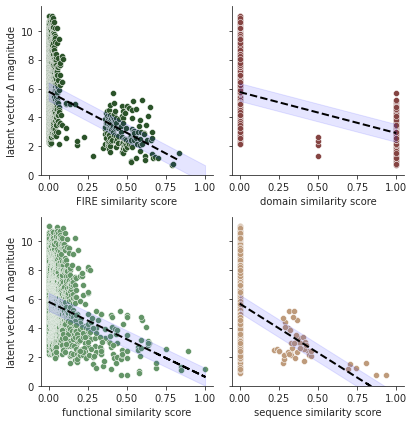

In [121]:
import seaborn as sbn

fig, axes = plt.subplots(2,2, figsize = (6,6), sharey = True)

sbn.scatterplot(x = similarity_frame['similarity_score'],
                y = refined_diff_magnitudes,
                color = '#2b5329',
                ax = axes[0,0])

axes[0,0].set_xlabel('FIRE similarity score')
axes[0,0].set_ylabel('latent vector Δ magnitude')

# axes[0,0].plot([0,0],[max_magnitude,min_magnitude], c = 'k', linestyle = '--', linewidth=2)
x_r, x_p = plot_linear_reg(similarity_frame['similarity_score'].values, refined_diff_magnitudes, axes[0,0],
                c = 'k', linestyle = '--', linewidth=2)

sbn.scatterplot(x = similarity_frame['domain_similarity'],
                y = refined_diff_magnitudes,
                color = '#854442',
                ax = axes[0,1])

axes[0,1].set_xlabel('domain similarity score')
axes[0,1].set_ylabel('latent vector Δ magnitude')

y_r, y_p = plot_linear_reg(similarity_frame['domain_similarity'].values, refined_diff_magnitudes, axes[0,1],
                c = 'k', linestyle = '--', linewidth=2)


sbn.scatterplot(x = similarity_frame['func_similarity'],
                y = refined_diff_magnitudes,
                color = '#649568',
                ax = axes[1,0])

axes[1,0].set_xlabel('functional similarity score')
axes[1,0].set_ylabel('latent vector Δ magnitude')

z_r, z_p = plot_linear_reg(similarity_frame['func_similarity'].values, refined_diff_magnitudes, axes[1,0],
                c = 'k', linestyle = '--', linewidth=2)

sbn.scatterplot(x = similarity_frame['seq_similarity'],
                y = refined_diff_magnitudes,
                color = '#be9b7b',
                ax = axes[1,1])

axes[1,1].set_xlabel('sequence similarity score')
axes[1,1].set_ylabel('latent vector Δ magnitude')

α_r, α_p = plot_linear_reg(similarity_frame['seq_similarity'].values, refined_diff_magnitudes, axes[1,1],
                c = 'k', linestyle = '--', linewidth=2)

# fig.suptitle("FIRE score/subscores vs latent vector difference magnitude")

plt.tight_layout()
sbn.despine()

axes[1,0].set_ylim(0,None)

plt.savefig("FIRE_sae_distance_comparison.png", dpi = 300)

In [126]:
import scipy

scipy.__version__

'1.5.4'

In [124]:
print(f"""
R^2 value | p-value
---
FIRE : {round(x_r**2,3)} | {x_p}
domain: {round(y_r**2,3)} | {y_p}
functional: {round(z_r**2,3)} | {z_p}
sequence: {round(α_r**2,3)} | {α_p}
""")


R^2 value | p-value
---
FIRE : 0.084 | 2.4736631361759204e-82
domain: 0.086 | 2.014135170450584e-84
functional: 0.049 | 1.6939401793852035e-47
sequence: 0.03 | 1.733432379262835e-29



In [76]:
import numpy as np, scipy.stats as st

print( np.mean(refined_diff_magnitudes) )
a = st.t.interval(0.95, len(refined_diff_magnitudes)-1, loc=np.mean(refined_diff_magnitudes), scale=st.sem(refined_diff_magnitudes))
print(a)
print( np.mean(refined_diff_magnitudes) -a[0] )
print( a[1] - np.mean(refined_diff_magnitudes) )


5.657063
(5.603396642291828, 5.710729372417645)
0.05366636506290856
0.05366636506290856


In [220]:
ci = 1.96 * np.std(refined_diff_magnitudes)/np.mean(refined_diff_magnitudes)
ci

0.4365369988851911

In [192]:
pwd

'/home/robertlink/Thesis_work/Chapter_3/Notebooks'

In [188]:
# y_true, y_pred

reg = stats.linregress(similarity_frame['func_similarity'], refined_diff_magnitudes)

In [214]:
reg.stderr

0.5260347491161489

In [215]:
ci = 1.96 * np.std(refined_diff_magnitudes)/np.mean(refined_diff_magnitudes)

In [217]:
refined_diff_magnitudes

array([13.712989 , 12.507425 ,  5.5245924, ...,  2.1756516,  1.7746756,
        2.7287164], dtype=float32)